In [1]:
%pip install scipy scikit-learn tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append('../scripts')
from glucose import get_sensor_glucose_data
from load_csv import load_csv
from sklearn import preprocessing
import pandas as pd



# Blood glucos vs ISIG
The insulin pump obtains from the sensor inserted on skin a list of values (Volts), the amount of volts will vary depending on the instersticial glucose level of the patient (ISIG). 
The insulin pump requires the measurement of blood glucose level (on blood) to match with the ISIG alues obtained from the sensor. That procedure is called calibration.
The next code will show the correspondence of a blood glucose level with the ISIG values obtained from the sensor.

In [3]:
FILE_PATH = "../data/raw/24-08-04.csv"
data_frame = load_csv(FILE_PATH)

glucose = get_sensor_glucose_data(data_frame)
#order glucose by "Sensor Glucose (mg/dL)" and then by "ISIG Value"
glucose = glucose.sort_values(by=["Sensor Glucose (mg/dL)", "ISIG Value"], ascending=[True, True])

#print the first 250 rows of the glucose dataframe
pd.set_option('display.max_rows', None)

print(glucose.head(250))


             Date      Time  Sensor Glucose (mg/dL)  ISIG Value
34863  2024/02/18  22:30:19                      40        7.55
34864  2024/02/18  22:25:19                      40        7.55
34865  2024/02/18  22:20:19                      40        8.21
34862  2024/02/18  22:35:19                      40        9.39
34866  2024/02/18  22:15:19                      40        9.41
33897  2024/02/22  07:51:27                      40        9.69
33896  2024/02/22  07:56:27                      40        9.72
33898  2024/02/22  07:46:27                      40        9.73
32116  2024/02/28  12:55:49                      40        9.81
33899  2024/02/22  07:41:27                      40        9.96
33895  2024/02/22  08:01:27                      40        9.99
33745  2024/02/22  20:31:28                      40       10.00
33900  2024/02/22  07:36:27                      40       10.40
9589   2024/05/17  10:35:44                      40       10.50
32115  2024/02/28  13:00:49             

Reviewing the Plot, we can conclude that to higher blood glucose, the major dispersion on ISIG values

[]

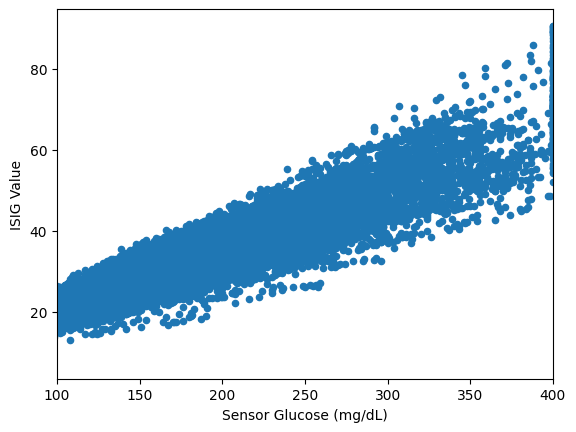

In [4]:

chart = glucose.plot.scatter(x="Sensor Glucose (mg/dL)", y="ISIG Value")
chart.set_xlim(100, 400)
chart.plot()


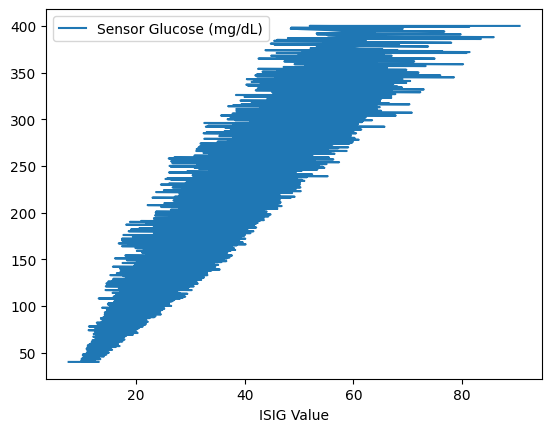

In [5]:
#print a line plot where x is the "ISIG Value" and y is the "Sensor Glucose (mg/dL)"
chart = glucose.plot.line(x="ISIG Value", y="Sensor Glucose (mg/dL)")


Checking patient's media of the blood glucose value

       Sensor Glucose (mg/dL)
34863                      40
34864                      40
34865                      40
34862                      40
34866                      40
33897                      40
33896                      40
33898                      40
32116                      40
33899                      40
33895                      40
33745                      40
33900                      40
9589                       40
32115                      40
32117                      40
9590                       40
24363                      40
24364                      40
33835                      41
34268                      41
34312                      42
33894                      42
28076                      42
23679                      42
33834                      43
34267                      43
34311                      43
35277                      43
31910                      43
33532                      43
33836                      44
33744     

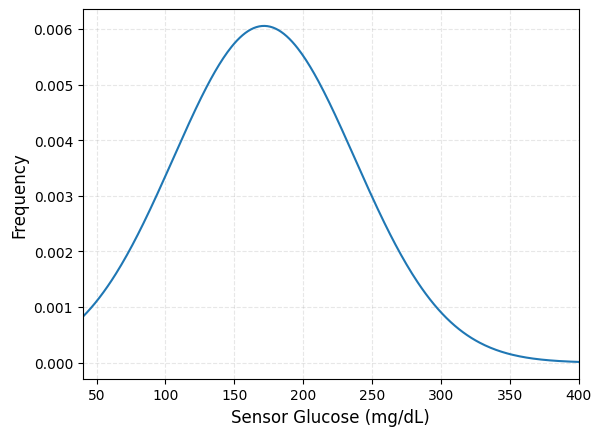

In [6]:
#get the gauss distribution of the glucose data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

df = glucose[["Sensor Glucose (mg/dL)"]]
print(df)

# Calculating mean and Stdev of AGW
df_mean = np.mean(df["Sensor Glucose (mg/dL)"])
df_std = np.std(df["Sensor Glucose (mg/dL)"])
 
# Calculating probability density function (PDF)
pdf = stats.norm.pdf(df["Sensor Glucose (mg/dL)"].sort_values(), df_mean, df_std)

# Drawing a graph
plt.plot(df["Sensor Glucose (mg/dL)"].sort_values(), pdf)
plt.xlim([40,400])  
plt.xlabel("Sensor Glucose (mg/dL)", size=12)    
plt.ylabel("Frequency", size=12)                
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

## Normalizing Glucose and ISIG values
In order to use the data to train a machine learning the data collected from insulin pump must be normalized.
We will be comparing the results using a Min-Max Scaler and a standard scaler.

In [7]:
minmax = preprocessing.MinMaxScaler()
standard = preprocessing.StandardScaler()
glucose["gs_minmax"] = minmax.fit_transform(glucose[["Sensor Glucose (mg/dL)"]])
glucose["isig_minmax"] = minmax.fit_transform(glucose[["ISIG Value"]])
glucose["gs_standard"] = standard.fit_transform(glucose[["Sensor Glucose (mg/dL)"]])
glucose["isig_standard"] = standard.fit_transform(glucose[["ISIG Value"]])

print(glucose[["Sensor Glucose (mg/dL)", "ISIG Value","gs_minmax","isig_minmax", "gs_standard", "isig_standard"]])

       Sensor Glucose (mg/dL)  ISIG Value  ...  gs_standard  isig_standard
34863                      40        7.55  ...    -1.996180      -2.189954
34864                      40        7.55  ...    -1.996180      -2.189954
34865                      40        8.21  ...    -1.996180      -2.127848
34862                      40        9.39  ...    -1.996180      -2.016810
34866                      40        9.41  ...    -1.996180      -2.014928
33897                      40        9.69  ...    -1.996180      -1.988580
33896                      40        9.72  ...    -1.996180      -1.985757
33898                      40        9.73  ...    -1.996180      -1.984816
32116                      40        9.81  ...    -1.996180      -1.977288
33899                      40        9.96  ...    -1.996180      -1.963173
33895                      40        9.99  ...    -1.996180      -1.960350
33745                      40       10.00  ...    -1.996180      -1.959409
33900                    

## Trying to train the module
With normalized data, we're going to try training the model using the 2 selected type of normalization (minmax vs standard) to see if we could get better results with the different approaches

In [31]:
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, train_test_split

#models setup
minmax_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
minmax_model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(0.01))

minmax = glucose[['gs_minmax', 'isig_minmax']]
#dividing minmax into training and validation sets
train, val = minmax[:int(0.8*len(minmax))], minmax[int(0.8*len(minmax)):]
X_train, X_val, y_train, y_val = train_test_split(minmax['gs_minmax'], minmax['isig_minmax'], test_size=0.2, random_state=42)

minmax_hist = minmax_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))



/home/alejandro/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 2/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 3/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/10
 82/693 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0021

Test data size 22164 rows


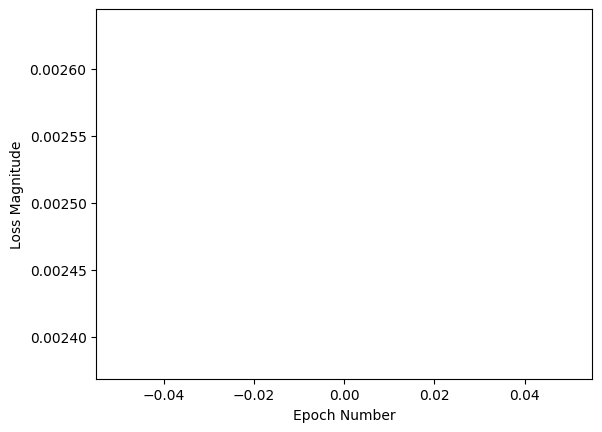

In [ ]:
print("Test data size {} rows".format(len(X_train)))
plt.xlabel("Epoch Number")
plt.ylabel("Loss Magnitude")
plt.plot(minmax_hist.history["loss"])
plt.show()